In [1]:
import pandas as pd
import datetime
from datetime import timedelta
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("matala2_cosmetics_2019-Nov.csv", low_memory=False)

In [3]:
df['event_time']= pd.to_datetime(df['event_time'])

In [4]:
df = df.sort_values(['user_id', 'event_time'])

## Q1

In [5]:
df['duration_to_next_event'] = df.groupby('user_session')['event_time'].diff(-1).dt.total_seconds().fillna(0)
df.loc[df.groupby('user_session')['event_time'].tail(1).index,'duration_to_next_event']= 0
df['duration_to_next_event'] = df['duration_to_next_event'].abs()
df.tail(10)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,duration_to_next_event
948,2019-11-01 01:03:07+00:00,view,5842947,1487580005511725929,NaN,NaN,5.56,566287645,963846e9-2850-434f-838b-d1318a13a401,0.0
946,2019-11-01 01:02:55+00:00,view,5700843,1487580007936033754,NaN,irisk,0.24,566287693,5dbccb0d-e25c-4667-80fb-31454d542715,0.0
950,2019-11-01 01:03:13+00:00,view,5728072,1487580009177546772,NaN,runail,29.29,566287718,909d05e9-e1af-4876-b3fc-169cd28e6d20,69.0
959,2019-11-01 01:04:22+00:00,view,37987,1487580009177546772,NaN,runail,42.86,566287718,909d05e9-e1af-4876-b3fc-169cd28e6d20,0.0
954,2019-11-01 01:03:49+00:00,view,5862272,1487580007675986893,NaN,freedecor,1.43,566287805,476fa026-19e2-4e11-bcf7-2875f35f0a98,0.0
963,2019-11-01 01:04:45+00:00,view,4766,1487580010796548183,NaN,runail,0.38,566287902,b543438c-b32d-4920-8cfe-c70d0453ceb8,0.0
967,2019-11-01 01:05:40+00:00,view,5587660,1487580008145748965,NaN,roubloff,4.75,566288008,42bd2b3c-02fe-400e-8068-041c3a709533,0.0
975,2019-11-01 01:06:53+00:00,view,5899435,1487580013950664926,NaN,NaN,19.89,566288039,209e5c4c-30af-40aa-8340-727e5f5c1584,70.0
980,2019-11-01 01:08:03+00:00,cart,5749199,1487580013053083824,stationery.cartrige,italwax,1.98,566288039,209e5c4c-30af-40aa-8340-727e5f5c1584,10.0
985,2019-11-01 01:08:13+00:00,cart,5766980,1487580013053083824,stationery.cartrige,italwax,1.98,566288039,209e5c4c-30af-40aa-8340-727e5f5c1584,0.0


## Q2

In [6]:
df['day_between'] = df.groupby('user_id')['event_time'].diff().dt.days
df['day_between2'] = (df['day_between'].fillna(0)> 5)|(df['day_between'].isnull())
df['funnel_number'] = df.groupby('user_id')['day_between2'].cumsum()
df.drop(['day_between','day_between2'], axis =1,inplace =True)

## Q3

In [7]:
df['index_in_funnel'] = df.groupby(['user_id', 'funnel_number'])['user_session'].transform(lambda x: x.factorize()[0] + 1)

## Q4

In [8]:
df['price'] = df['price'].apply(lambda x: re.findall("[\d.]+",x))
df['price'] =df['price'].apply(lambda x: np.array(x)).astype(float)

## Q5

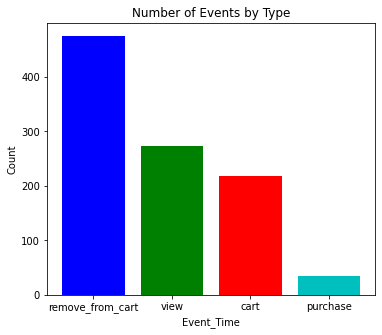

In [9]:
eventType = df['event_type'].unique()
count_values_events = df['event_type'].value_counts()
names = eventType.tolist()
values = count_values_events.tolist()
plt.figure(figsize=(20, 5))
colors = ['b', 'g', 'r', 'c']
plt.subplot(131)
plt.bar(names, values, color=colors)
plt.xlabel('Event_Time')
plt.ylabel('Count')
plt.title('Number of Events by Type')
plt.show()

## Q6

In [61]:
session_data = df[['user_id', 'user_session' , 'funnel_number', 'index_in_funnel']].drop_duplicates(subset = 'user_session')

In [63]:
total_events = df.groupby('user_session').size().reset_index(name='total_events')


In [70]:
duration = df.groupby('user_session')['event_time'].agg(lambda x: x.max() - x.min()).reset_index(name='duration')

In [65]:
viewed_products = df.groupby('user_session').apply(lambda x: x.loc[x['event_type'] == 'view', 'product_id'].tolist()).reset_index(name='viewed_products')

In [66]:
added_to_cartClear = df.groupby( 'user_session').apply(lambda x: x.loc[x['event_type'] == 'cart', 'product_id'].tolist()).reset_index(name='cart_products')
added_to_cart2 = added_to_cartClear[added_to_cartClear['cart_products'].apply(lambda x: len(x) != 0) == True].reset_index()
added_to_cart2.drop('index', axis =1,inplace =True)

In [67]:
purchasesClear=df.groupby('user_session').apply(lambda x: x.loc[x['event_type'] == 'purchase', 'product_id'].tolist()).reset_index(name='purchases')
purchases = purchasesClear[purchasesClear['purchases'].apply(lambda x: len(x) != 0) == True].reset_index()
purchases.drop('index', axis =1,inplace =True)
purchases

,user_session,purchases
0,34adbc64-eebc-4d45-8542-547b9c20f6c1,"[35152, 5749199, 5759492, 5810673, 5775814, 57..."
1,3ad69360-e328-454a-b1f8-0e0901e1e344,"[5532, 5549786, 5550302, 5693001, 5710313, 571..."
2,861ab2f1-b2e5-886f-a93b-5b067eff081f,"[24380, 26765, 5573498, 5586154, 5739918, 5766..."
3,9f777569-bdf3-47e5-a3d4-dfc26beb29cb,"[5839412, 5823969, 5810480]"
4,dd20e3bf-021f-4633-a9c7-18b6158b2006,"[5878673, 5857921, 5857777, 5854569, 5837825]"
5,e707213f-7920-49e5-9386-55e3a516e069,"[5809910, 5855117]"


In [68]:
session_data = total_events.merge(duration, on='user_session', how='outer').merge(viewed_products, on='user_session', how='outer').merge(added_to_cart2, on='user_session', how='outer').merge(purchases, on='user_session', how='outer').merge(session_data, on='user_session', how='outer')

In [69]:
session_data

,user_session,total_events,duration,viewed_products,cart_products,purchases,user_id,funnel_number,index_in_funnel
0,000a16cf-3a42-48f5-98e4-caf0bffbfab3,1,0 days 00:00:00,[5696324],NaN,NaN,390049318,1,1
1,017e38ca-43b3-479a-bb6a-745fe1729048,1,0 days 00:00:00,[5899436],NaN,NaN,511973458,1,8
2,0226dd29-c6a4-4f3c-be5e-0222c3d9f5af,2,0 days 00:04:44,"[5670001, 5808567]",NaN,NaN,566276650,1,1
3,02729a78-7e1a-484e-8bcb-19cc06e25ed6,1,0 days 00:00:00,[5677465],NaN,NaN,566286232,1,1
4,037e2ba9-1446-49c6-9723-dcfa7f9da3b8,3,0 days 00:00:11,[5837825],"[5837825, 5837825]",NaN,514649199,1,2
...,...,...,...,...,...,...,...,...,...
248,f6128c15-e9b7-4c28-a6f4-a96b3c4ba815,1,0 days 00:00:00,[82955],NaN,NaN,513894996,1,1
249,f8ab73fb-2bf1-4fce-bd7e-20c7bda55da4,12,0 days 00:13:22,[5859204],"[5687864, 5659922, 5693964, 5885845]",NaN,465774735,1,1
250,fcc83858-2c41-4e63-8ff6-0e0f2a39ec75,1,0 days 00:00:00,[5839700],NaN,NaN,455571231,1,5
251,fe14c5f3-60cd-4363-a577-ce29ca523f1c,2,0 days 00:00:17,[5855510],NaN,NaN,341955890,1,1
